In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import math
import models.self_model as models
import models.densenet as densenet
import get_data

In [2]:
data_path = "C://Users//shjdl//Desktop//DM_project//data//"
train_path = data_path+"train1.csv"
valid_path = data_path+"validation.csv"

raw_data = pd.read_csv(train_path, iterator=True)
all_data = raw_data.get_chunk(50000).values.astype('uint8')
# train_data = all_data  #train final model
train_data = all_data[0:50000]  #test model performance
valid_data = all_data[45000:50000]
all_data = None

In [3]:
BATCH_SIZE = 32
NUM_EPOCHS = 60
LR = 0.1

# model = models.AllConvNet(3000)
# model = models.SimpleNet()
model = densenet.DenseNet([6,12,32,32], 32)

best_model = model

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.99))
# optimizer = optim.Adadelta(model.parameters(), 0.9)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-4)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,50], gamma=0.1)

simple_transform = transforms.Compose([
                    transforms.ToTensor(),
                    ])
train_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ColorJitter(0.05, 0.05, 0.05, 0.05),
                    transforms.ToTensor(),
                    ])




In [4]:
train_dataset = get_data.TrainDataset(train_data, 50000,train_transform)
# train_dataset2 = get_data.TrainDataset(valid_data, 5000,train_transform)
# valid_dataset = get_data.TrainDataset(valid_data,800,simple_transform)
test_dataset = get_data.TrainDataset(train_data,800,simple_transform)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# train_loader2 = data.DataLoader(train_dataset2, batch_size=16, shuffle=True, drop_last=True)

In [ ]:
best_acc = 0.99
tloss = []
epochloss=[]
valid = []
test = []
processed = 0
model = model.cuda()

for epoch in range(NUM_EPOCHS):    
    model.train()    
    scheduler.step()
    
    for images, labels in tqdm(train_loader,disable = True):
        images = images.type(torch.FloatTensor).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        out = model(images)

        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            
    print("epoch %d,current entropy is %f" % (epoch, loss.data.item()))
    tloss.append(loss.data.item())        
    train_acc = 0
    test_acc = 0
    
    model.eval()  ##
    test_loader = data.DataLoader(test_dataset, batch_size=30, shuffle=True, drop_last=False)
    for images, labels in tqdm(test_loader,disable =True):
        images = images.type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)
        images = images.cuda()
        labels = labels.cuda()
        model = model.cuda()
        out = model(images)
        _, pred = torch.max(out, 1)
        
        num_correct = (pred == labels).sum()
        test_acc += num_correct.item()
    test.append(test_acc / 800)  
    if test_acc / 800>best_acc:
        best_acc = test_acc / 800
        best_model = model
        model_name="densenet_alldata-"
        datetime =time.strftime('%Y.%m.%d',time.localtime(time.time()))
        PATH = "./model-" + model_name+ datetime + ".pt"
        torch.save(best_model, PATH) 
        
    
#     valid_loader = data.DataLoader(valid_dataset, batch_size=30, shuffle=True, drop_last=False)
#     for images, labels in tqdm(valid_loader,disable =True):
#         images = images.type(torch.FloatTensor)
#         labels = labels.type(torch.LongTensor)
#         images = images.cuda()
#         labels = labels.cuda()
#         model = model.cuda()
#         out = model(images)
#         _, pred = torch.max(out, 1)
        
#         num_correct = (pred == labels).sum()
#         train_acc += num_correct.item()
#     epochloss.append(loss.data.item())
#     valid.append(train_acc / 800)
    
    print("current test accuracy is %f , current valid accuracy is %f " % (test_acc/800, train_acc/800))


epoch 0,current entropy is 1.657895
current test accuracy is 0.391250 , current valid accuracy is 0.000000 
epoch 1,current entropy is 1.208163
current test accuracy is 0.610000 , current valid accuracy is 0.000000 
epoch 2,current entropy is 1.347778
current test accuracy is 0.650000 , current valid accuracy is 0.000000 
epoch 3,current entropy is 1.013291
current test accuracy is 0.697500 , current valid accuracy is 0.000000 
epoch 4,current entropy is 0.706646
current test accuracy is 0.711250 , current valid accuracy is 0.000000 


In [13]:
correct = list(0. for i in range(0,10))
total = list(0. for i in range(0,10))
pred_correct = list(0. for i in range(0,10))
pred_total = list(0. for i in range(0,10))
valid_dataset = get_data.TrainDataset(valid_data,3000,simple_transform)
valid_loader = data.DataLoader(valid_dataset, batch_size=20, shuffle=True, drop_last=False)
model = best_model
model.eval()
for i, (images, labels) in enumerate(valid_loader):
            images = images.type(torch.FloatTensor).cuda()
            labels = labels.type(torch.LongTensor).cuda()

            output = model(images)

            prediction = torch.argmax(output, 1)
            res = prediction == labels
            for label_idx in range(len(labels)):
                label_single = labels[label_idx]
                label_pred = prediction[label_idx]
                correct[label_single] += res[label_idx].item()
                total[label_single] += 1
                pred_correct[label_pred] += res[label_idx].item()
                pred_total[label_pred] += 1
                
# acc_str = 'Accuracy: %f'%(sum(correct)/sum(total))
print("Actual slasses and their accuracy:")
for acc_idx in range(0,10):
            try:
                acc = correct[acc_idx]/total[acc_idx]
            except:
                acc = 0
            finally:
                print(acc)
print("Predicted classes and their accuracy:")
for acc_idx in range(0,10):
            try:
                acc2 = pred_correct[acc_idx]/pred_total[acc_idx]
            except:
                acc2 = 0
            finally:
                print(acc2)


RuntimeError: CUDA error: out of memory

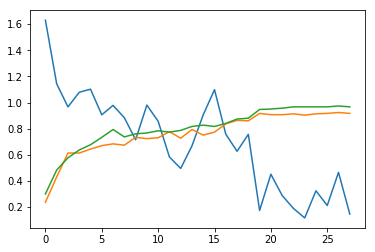

In [9]:
plt.plot(epochloss)
plt.plot(valid)
plt.plot(test)
plt.show()